# Predicting a Patient's Succesful Completion of Drug Treatment Program

We are using 2011 nationwide data of patients discharged from drug treatment programs (either through completion of the program or by dropping out). The goal is to analyse some of the attributes of the patient or their circumstances to see if they may have some impact on the outcome of whether the patient completes treatment or drops out against professional advice.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

# Read in and clean some of the data 

In [2]:
df_raw = pd.read_table('Discharge_Data.tsv')

We need to subset our data to the observations where the REASON for discharge from the program was either:

1: Treatment Completed, or 

2: Left Against Professional Advice

In [3]:
df = df_raw.loc[df_raw['REASON'].isin([1,2])]

Since -9 represents NA/mising values in the dataset, map to NaN for easier reading and computation with pandas/numpy.
Also, convert outcome variable REASON to binary 0,1 for easier computation:

In [4]:
df = df.replace(-9, np.nan)
df['REASON'] = df['REASON'].replace(2, 0)

In previewing the data below, there are 65 variables including the outcome. We need to pick only a handful to analyse in our model to ensure it is manageable and to prevent overfitting.

In [5]:
df.head()

,CASEID,DISYR,AGE,GENDER,RACE,ETHNIC,MARSTAT,EDUC,EMPLOY,DETNLF,...,BARBFLG,SEDHPFLG,INHFLG,OTCFLG,OTHERFLG,ALCDRUG,DSMCRIT,PSYPROB,HLTHINS,PRIMPAY
2,3,2011,11,1.0,5.0,5.0,3.0,4.0,4.0,3.0,...,0,0,0,0,0,3,13.0,2.0,NaN,9.0
3,4,2011,6,2.0,5.0,5.0,3.0,4.0,3.0,NaN,...,0,0,0,0,0,2,NaN,1.0,4.0,5.0
4,5,2011,9,2.0,5.0,5.0,4.0,3.0,1.0,NaN,...,0,0,0,0,0,1,9.0,1.0,4.0,5.0
5,6,2011,5,1.0,4.0,5.0,1.0,4.0,4.0,6.0,...,0,0,0,0,0,2,NaN,2.0,4.0,8.0
6,7,2011,6,1.0,5.0,5.0,1.0,3.0,2.0,NaN,...,0,0,0,0,0,2,7.0,2.0,NaN,1.0


As displayed above, most of the data is categorical but represented by a numerical value. The variables I plan to include in the model are dictated below:

Variable | Description | Type of Variable
---| ---| ---
AGE | (Values 2-11) Mapped to Age Ranges from 11 and under to 55+ | categorical
GENDER | 1 = Male, 2 = Female | categorical
EDUC | (Values 1-5) Mapped to Years of Education Ranges, from 8 and less to 16+ | categorical
EMPLOY | (Values 1-4) Mapped to Employment Status: FT, PT, Unemployed, Not in Labour Force | categorical
LIVARAG | (Values 1-3) Living Arrangement: Homeless, Independent, Dependent | categorical
LOS | Length of Stay # of days til 30 (after 30, ranges: 31 = 31-45 days, 32 = 46=60 days, etc.) | continuous/categorical 
PSOURCE | (Values 1-7) Primary Source of Referral | categorical
NOPRIOR | # of Prior Treatment Episodes | continuous
NUMSUBS | Number of Substances | continous
SUB1 | (Values 1-20) Mapped to Primary Substance of Abuse | categorical
REASON | 1 = Treatment Completed , 0 = Dropped Out | categorical

In [6]:
# subset data according to above variables
df = df[['AGE', 'GENDER', 'EDUC', 'EMPLOY', 'LIVARAG', 'LOS', 'PSOURCE', 'NOPRIOR', 'NUMSUBS', 'SUB1', 'REASON']].dropna()

# created version with mapped variables for easier comprehension, use unmapped version for charting ordinal variables
df_mapped = df.copy()

We can take a quick look at distributions of chosen variables - note despite all being categorical some are ordinal such as AGE, EDUC, LOS (Length of Stay), NOPRIOR (Number of Prior Treatments), NUMSUBS (Number of Substances):

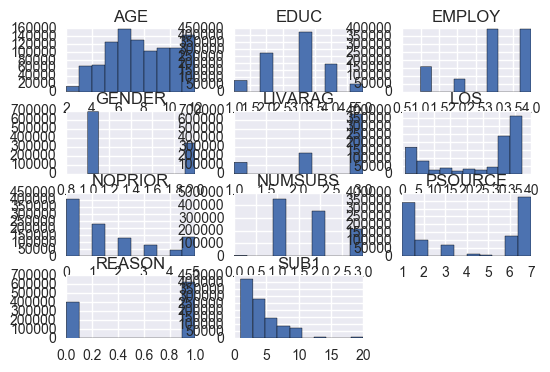

In [7]:
df.hist();

Focusing on the distribution of the AGE ranges between those who completed treatment and those who dropped out:

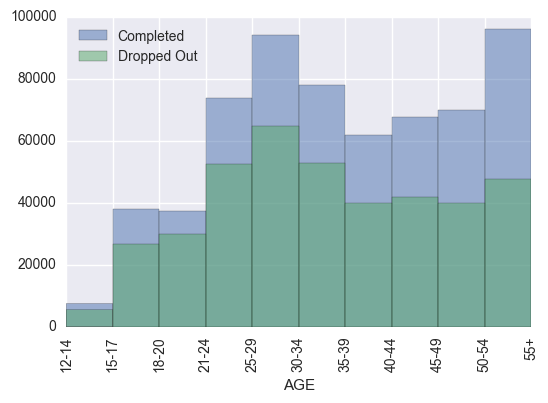

In [8]:
plt.hist(df[df['REASON'] == 1]['AGE'], alpha = 0.5, label = 'Completed')
plt.hist(df[df['REASON'] == 0]['AGE'], alpha = 0.5, label = 'Dropped Out')
plt.legend(loc = 'upper left');
x = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
labels =  ['12-14', '15-17', '18-20', '21-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50-54', '55+']
plt.xticks(x, labels, rotation='vertical');
plt.xlabel('AGE');

It looks like there is a downward trend in those dropping out of the program as the age range increases, so it could age could be an indicative variable in our model. We can further analyse this in conjunction with gender to see if this is true across both sexes:

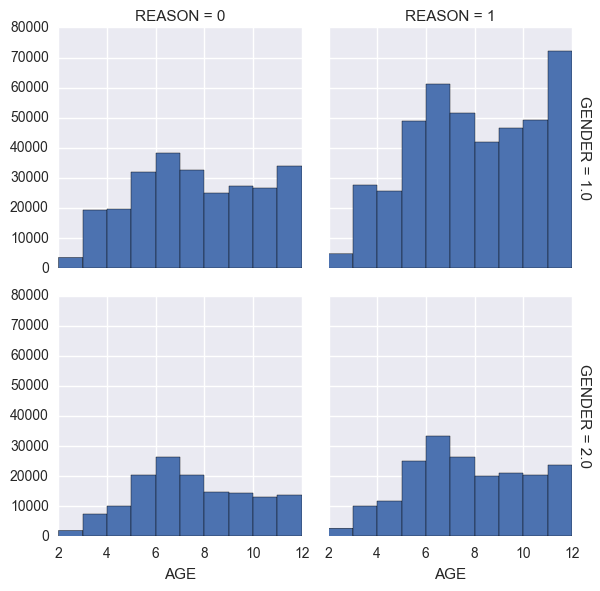

In [9]:
# Reason = 1: Completed Treatment, Reason = 2: Dropped Out
# Gender = 1: Male, Gender = 2: Female
g = sns.FacetGrid(df, row = 'GENDER', col = 'REASON', margin_titles = True)
g.map(plt.hist, 'AGE');

The majority of those who finish treatment are men older than 55+. Once again it looks like the distributions seem similar at first glance.

# Mapping Variables to Categorical Values for Models

Age Ranges:

In [10]:
AGE_Map = {1: '11 and Under',
           2: '12 to 14',
           3: '15 to 17',
           4: '18 to 20',
           5: '21 to 23',
           6: '25 to 29',
           7: '30 to 34',
           8: '35 to 39',
           9: '40 to 44',
           10: '45 to 49',
           11: '50 to 54',
           12: '55+'}

df_mapped['AGE'].replace(AGE_Map, inplace = True)

Gender:

In [11]:
GENDER_Map = {1: 'Male',
              2: 'Female'}
df_mapped['GENDER'].replace(GENDER_Map, inplace = True)

Education:

In [12]:
EDUC_Map = {1: '00 to 08',
            2: '09 to 11',
            3: '12',
            4: '13 to 15',
            5: '16+'}
df_mapped['EDUC'].replace(EDUC_Map, inplace = True)

Employment Status:

In [13]:
EMPLOY_Map = {1: 'Full Time',
              2: 'Part Time',
              3: 'Unemployed',
              4: 'Not in Labour Force'}
df_mapped['EMPLOY'].replace(EMPLOY_Map, inplace = True)

Living Arrangement:

In [14]:
LIVARAG_Map = {1: 'Homeless',
               2: 'Dependent',
               3: 'Independent'}
df_mapped['LIVARAG'].replace(LIVARAG_Map, inplace = True)

Length of Stay:

Although the data is continuous for stays that are 1-30 days long, the rest of the lengths are measured in range. Therefore we should convert the continuous values to ranges to maintain consistency when testing the variable.

In [15]:
LOS_map = {31: '031-045',
           32: '046-060',
           33: '061-090',
           34: '090-120',
           35: '121-180',
           36: '181-365',
           37: '365+'
           }
df_mapped['LOS'].replace(LOS_map, inplace = True)
df_mapped['LOS'] = np.where(df_mapped.LOS.isin(range(1,16)), '001-015', df_mapped['LOS'])
df_mapped['LOS'] = np.where(df_mapped.LOS.isin(range(16,31)), '016-030', df_mapped['LOS'])

Principal Source of Referral:

In [16]:
PSOURCE_Map = {1: 'Individual',
               2: 'Drug Abuse Provider',
               3: 'Other Health Provider',
               4: 'School',
               5: 'Employer',
               6: 'Other Community Referral',
               7: 'Court'}
df_mapped['PSOURCE'].replace(PSOURCE_Map, inplace = True)

Primary Drug Used:

In [17]:
# mapping primary drug used - since there are 20 unique categories, take the 6 most common and code the rest as 'Other'
df_mapped['SUB1'].value_counts(ascending = False)

2.0     415986
4.0     194717
5.0     143348
7.0      81976
3.0      81417
10.0     70587
13.0      8517
20.0      6876
1.0       5412
11.0      4852
8.0       3114
6.0       2996
16.0      1369
9.0        959
18.0       693
17.0       683
12.0       662
15.0       502
14.0       230
Name: SUB1, dtype: int64

In [18]:
SUB1_Map = {2: 'Alcohol',
            3: 'Crack Cocaine',
            4: 'Marijuana',
            5: 'Heroine',
            7: 'Opiates Synthetics',
            10: 'Meth'}
df_mapped['SUB1'].replace(SUB1_Map, inplace = True)
df_mapped['SUB1'] = np.where(df_mapped.SUB1.isin([1,6,8,9,11,12,13,14,15,16,17,18,18,20]), 'Other', df_mapped['SUB1'])

In [19]:
df_mapped.head()

,AGE,GENDER,EDUC,EMPLOY,LIVARAG,LOS,PSOURCE,NOPRIOR,NUMSUBS,SUB1,REASON
3,25 to 29,Female,13 to 15,Unemployed,Independent,046-060,Individual,1.0,2,Opiates Synthetics,0
4,40 to 44,Female,12,Full Time,Independent,016-030,Other Community Referral,3.0,1,Alcohol,1
6,25 to 29,Male,12,Part Time,Independent,121-180,Court,2.0,1,Marijuana,1
7,25 to 29,Male,13 to 15,Not in Labour Force,Homeless,001-015,Individual,5.0,2,Heroine,0
8,35 to 39,Male,16+,Full Time,Independent,181-365,Individual,3.0,2,Meth,1


# Look at Distributions of the Mapped [Categorical] Data

In [20]:
features = ['AGE', 'GENDER', 'EDUC', 'EMPLOY', 'LIVARAG', 'LOS', 'PSOURCE', 'SUB1']

for feature in features:
    print pd.crosstab(index = df_mapped[feature], columns = df_mapped['REASON'], normalize = 'index'), '\n'

REASON           0         1
AGE                         
12 to 14  0.423148  0.576852
15 to 17  0.414261  0.585739
18 to 20  0.443965  0.556035
21 to 23  0.414726  0.585274
25 to 29  0.407208  0.592792
30 to 34  0.403946  0.596054
35 to 39  0.392508  0.607492
40 to 44  0.381801  0.618199
45 to 49  0.362967  0.637033
50 to 54  0.341443  0.658557
55+       0.318304  0.681696 

REASON         0         1
GENDER                    
Female  0.423676  0.576324
Male    0.375298  0.624702 

REASON           0         1
EDUC                        
00 to 08  0.423015  0.576985
09 to 11  0.447220  0.552780
12        0.378444  0.621556
13 to 15  0.354772  0.645228
16+       0.291284  0.708716 

REASON                      0         1
EMPLOY                                 
Full Time            0.304637  0.695363
Not in Labour Force  0.399741  0.600259
Part Time            0.377235  0.622765
Unemployed           0.419624  0.580376 

REASON              0         1
LIVARAG                        


To summarize some of the observations in our selected variables:

AGE: As the age ranges increase, the patients were more likely to complete their treatment.

GENDER: Males were slightly more likely to complete their treatment. 

EMPLOY: Those working Full-Time were most likely to complete their treatment; we can speculate this is most likely due to preasures from their employer to maintain their employment status.

LIVARAG: Surprisingly, those who were homeless had the highest rate of completing their treatment.

LOS: As the length of stay increased, there seems to be a positive trend towards completing treatment. However there may be some implicit bias in this, as those who dropped out early clearly will have shorter lengths of stay compared to if they had successfully completed the regimen. The highest completion rates is in the 90-365 day range, once past 1 year it seems to decrease again.

PSOURCE: Those with court-ordered and employer-ordered treatments completed the treatment at much higher rates than any other source of referral.

SUB1: Those being treated primarily for alcohol abuse had higher rates of completion.

# Build a Model Using Logistic Regression

In [21]:
dummies = pd.get_dummies(df_mapped[['AGE', 'GENDER', 'EDUC', 'EMPLOY', 'LIVARAG', 'LOS', 'PSOURCE', 'SUB1']], drop_first = True)

In [22]:
df_mapped1 = df_mapped.join(dummies)

In [23]:
y = df_mapped1['REASON']
X = df_mapped1.drop(['AGE', 'GENDER', 'EDUC', 'EMPLOY', 'LOS', 'LIVARAG', 'PSOURCE', 'SUB1', 'REASON'], axis = 1, inplace = False)

from sklearn import linear_model
logr = linear_model.LogisticRegression()
logr.fit(X,y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [24]:
pd.DataFrame(np.exp(logr.coef_).T, index = X.columns.values)

,0
NOPRIOR,1.063498
NUMSUBS,0.881033
AGE_15 to 17,1.056868
AGE_18 to 20,0.805887
AGE_21 to 23,0.838267
AGE_25 to 29,0.833312
AGE_30 to 34,0.815302
AGE_35 to 39,0.814862
AGE_40 to 44,0.831431
AGE_45 to 49,0.874963


# Summarize Logistic Regression Results

AGE:
The control for variable AGE range is 12-14. The odds of completion improve as the AGE range increases, but according to this model the highest odds of completion are in the 12-14 and 15-17 AGE ranges, followed by AGE 55+ and 50-54.

GENDER:
As speculated above, males had a higher odds of completion compared to the females.

EDUC:
The odds of completion increase as years of education increases.



In [25]:
from sklearn.cross_validation import cross_val_score, KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
cv = StratifiedKFold(y ,n_folds=5, shuffle=True)
perf = cross_val_score(logr, X, y, cv=cv, scoring = "accuracy")
print perf.mean(), perf.std()

0.629615107251 0.00114337318274


In [26]:
len(df_mapped[df_mapped.REASON == 1])/np.float32(len(df_mapped))

0.60877201198950914

Our model is performing with 63% accuracy; given a baseline performance of 60.8% this is not a strong model. We can use gridsearch to see if changing parameters will improve our accuracy:

In [28]:
logr = linear_model.LogisticRegression()
params = {"C": [0.000001, 0.001, 1, 100, 10000], "penalty": ["l1", "l2"]}

from sklearn.grid_search import GridSearchCV
logr_grid = GridSearchCV(logr, params, n_jobs =-1, verbose = False)
df_sub = df_mapped1.sample(frac = 0.1)
y_sub = df_sub['REASON']
X_sub = df_sub.drop(['AGE', 'GENDER', 'EDUC', 'EMPLOY', 'LOS', 'LIVARAG', 'PSOURCE', 'SUB1', 'REASON'], axis = 1, inplace = False)
logr_grid.fit(X_sub, y_sub)

GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'penalty': ['l1', 'l2'], 'C': [1e-06, 0.001, 1, 100, 10000]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=False)

In [29]:
print logr_grid.best_params_
print logr_grid.best_score_

{'penalty': 'l2', 'C': 1}
0.629954141867


In [30]:
logr = linear_model.LogisticRegression(penalty = 'l2', C = 1)
logr.fit(X,y)

cv = StratifiedKFold(y ,n_folds=5, shuffle=True)
perf = cross_val_score(logr, X, y, cv=cv, scoring = "accuracy")
print perf.mean(), perf.std()

0.629699992801 0.001154039661


Using the regularization parameters did not improve our model.

Use Recursive Feature Elimination to see if we can hone in on some attributes to rebuild a logr model

In [34]:
from sklearn.feature_selection import RFE
rfe = RFE(logr, 10)
rfe = rfe.fit(X,y)

In [54]:
pd.DataFrame(rfe.ranking_.T, index = X.columns.values).sort_index(by = 0)

/Users/CarolineWu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: by argument to sort_index is deprecated, pls use .sort_values(by=...)
  if __name__ == '__main__':


,0
SUB1_Other,1
SUB1_Opiates Synthetics,1
LOS_090-120,1
LOS_181-365,1
PSOURCE_School,1
LOS_121-180,1
SUB1_Heroine,1
SUB1_Meth,1
SUB1_Marijuana,1
SUB1_Crack Cocaine,1


In [55]:
df_mapped_rfe = df_mapped.copy()
LOS1_map = {'001-015': 'Under 90',
            '016-030': 'Under 90',
            '031-045': 'Under 90',
            '046-060': 'Under 90',
            '061-090': 'Under 90',
            }
df_mapped_rfe['LOS'].replace(LOS1_map, inplace = True)

In [56]:
EDUC1_map = {'00 to 08': 'Under 12',
             '09 to 11': 'Under 12',
            }
df_mapped_rfe['EDUC'].replace(EDUC1_map, inplace = True)

In [57]:
df_mapped_rfex = df_mapped_rfe[['EDUC', 'LOS', 'PSOURCE', 'SUB1', 'REASON']]

In [59]:
dummies_rfex = pd.get_dummies(df_mapped_rfex[['EDUC', 'LOS', 'PSOURCE', 'SUB1']], drop_first = True)

In [60]:
df_mapped_rfex = df_mapped_rfex.join(dummies_rfex)

In [65]:
X_rfex = df_mapped_rfex.drop(['EDUC', 'LOS', 'PSOURCE', 'SUB1', 'REASON'], axis = 1)
y_rfex = df_mapped_rfex['REASON']

In [66]:
logr_rfex = linear_model.LogisticRegression()
logr_rfex.fit(X_rfex,y_rfex)

perf_rfex = cross_val_score(logr_rfex, X_rfex, y_rfex, cv=cv, scoring = "accuracy")
print perf_rfex.mean(), perf_rfex.std()

0.614166706482 0.000830102364962


# Try Random Forest Classifier

In [69]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
dummies = pd.get_dummies(df_mapped[['AGE', 'GENDER', 'EDUC', 'EMPLOY', 'LIVARAG', 'LOS', 'PSOURCE', 'SUB1']], drop_first = False)
df_mapped2 = df_mapped.join(dummies)
y = df_mapped2['REASON']
X = df_mapped2.drop(['AGE', 'GENDER', 'EDUC', 'EMPLOY', 'LOS', 'LIVARAG', 'PSOURCE', 'SUB1', 'REASON'], axis = 1, inplace = False)

rf.fit(X,y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [70]:
perf = cross_val_score(rf, X, y, cv=cv)
print perf.mean(), perf.std()

0.628897955452 0.000673723979861


In [73]:
pd.DataFrame(rf.feature_importances_.T, index = X.columns.values).sort_index(by = 0, ascending = False)

/Users/CarolineWu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: by argument to sort_index is deprecated, pls use .sort_values(by=...)
  if __name__ == '__main__':


,0
NOPRIOR,0.220709
NUMSUBS,0.104624
SUB1_Alcohol,0.027594
AGE_30 to 34,0.024574
AGE_25 to 29,0.024071
LOS_001-015,0.023321
AGE_40 to 44,0.022454
AGE_35 to 39,0.022343
EDUC_12,0.022158
AGE_21 to 23,0.021124


In [75]:
dummies_rfe1 = pd.get_dummies(df_mapped_rfe[['EDUC', 'LOS', 'PSOURCE', 'SUB1']], drop_first = False)
df_mapped_rfe1 = df_mapped_rfe.join(dummies_rfe1).drop(['AGE', 'GENDER', 'EMPLOY', 'LIVARAG','NOPRIOR','NUMSUBS'], axis = 1)

X_rfe1 = df_mapped_rfe1.drop(['EDUC', 'LOS', 'PSOURCE', 'SUB1', 'REASON'], axis = 1)
y_rfe1 = df_mapped_rfe1['REASON']

rf.fit(X_rfe1, y_rfe1)
perf = cross_val_score(rf, X_rfe1, y_rfe1, cv=cv)
print perf.mean(), perf.std()

0.635113221496 0.000838630673118


In [95]:
rf = RandomForestClassifier()
params = {"max_depth": [5, 10, 15, 20, 30],"max_features":[0.1, 0.3, 0.7, 1], \
         "min_samples_split":[5 , 10 , 15]}

rf_grid = GridSearchCV(rf, params, n_jobs=-1, verbose=False)
rf_grid.fit(X_sub,y_sub)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'max_features': [0.1, 0.3, 0.7, 1], 'min_samples_split': [5, 10, 15], 'max_depth': [5, 10, 15, 20, 30]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=False)

In [96]:
print rf_grid.best_estimator_
print rf_grid.best_score_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=15, max_features=0.7, max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=15,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
0.649458483755


In [97]:
rf = RandomForestClassifier(max_depth = 15, max_features = 0.7, min_samples_split =15)
rf.fit(X, y) 
perf = cross_val_score(rf, X, y, cv=cv)
print perf.mean(), perf.std()

0.66718867105 0.000996444802702


In [88]:
X_rfe1_sub = df_mapped_rfe1.sample(frac = 0.1).drop(['EDUC', 'LOS', 'PSOURCE', 'SUB1', 'REASON'], axis = 1)
y_rfe1_sub = df_mapped_rfe1.sample(frac = 0.1)['REASON']
rf_grid.fit(X_rfe1_sub,y_rfe1_sub)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'max_features': [0.1, 0.3, 0.7, 1], 'min_samples_split': [5, 10, 15], 'max_depth': [5, 10, 15, 20, 30]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=False)

In [89]:
print rf_grid.best_estimator_
print rf_grid.best_score_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features=0.1, max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
0.609269196995


In [92]:
rf = RandomForestClassifier(max_depth = 5, max_features = 0.1, min_samples_split = 5)
rf.fit(X_rfe1, y_rfe1)
perf = cross_val_score(rf, X_rfe1, y_rfe1, cv=cv)
print perf.mean(), perf.std()

0.614462346528 0.00299104528162


In [93]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(X_sub,y_sub)
perf = cross_val_score(knn, X_sub, y_sub)
print perf.mean(), perf.std()

KeyboardInterrupt: 

In [98]:
from sklearn.metrics import roc_curve
fpr, tpr, thresh = roc_curve(y,rf_grid.best_estimator_.predict_proba(X).T[1])
fig, ax = plt.subplots()
pd.DataFrame({'tpr': tpr, 'fpr': fpr}).plot(
        x='fpr', y='tpr', ax=ax, label="ROC")

ValueError: Number of features of the model must  match the input. Model n_features is 42 and  input n_features is 50 